# Final Project

## By Team VC

### Intro to Co Purchasing Network | Toy reviews

For our final, we decided our analysis will use real world data supplied from the [Amazon co-purchasing network (March 2, 2003)](https://snap.stanford.edu/data/amazon0302.html). This network consisted of over 500 millions nodes with two types of nodes: products and reviewers. Each review about a products represents an edge between a reviewer and a product. Our starter network for the analysis is the Toy reviews sub network, so our limited scope is more susceptible for visual QAs. Let's begin our analysis!

To see a presentation for this project, please [click here](https://drive.google.com/file/d/1RiRVww6S3YW7asljx7pBvywh0KFEwbue/view?usp=sharing).


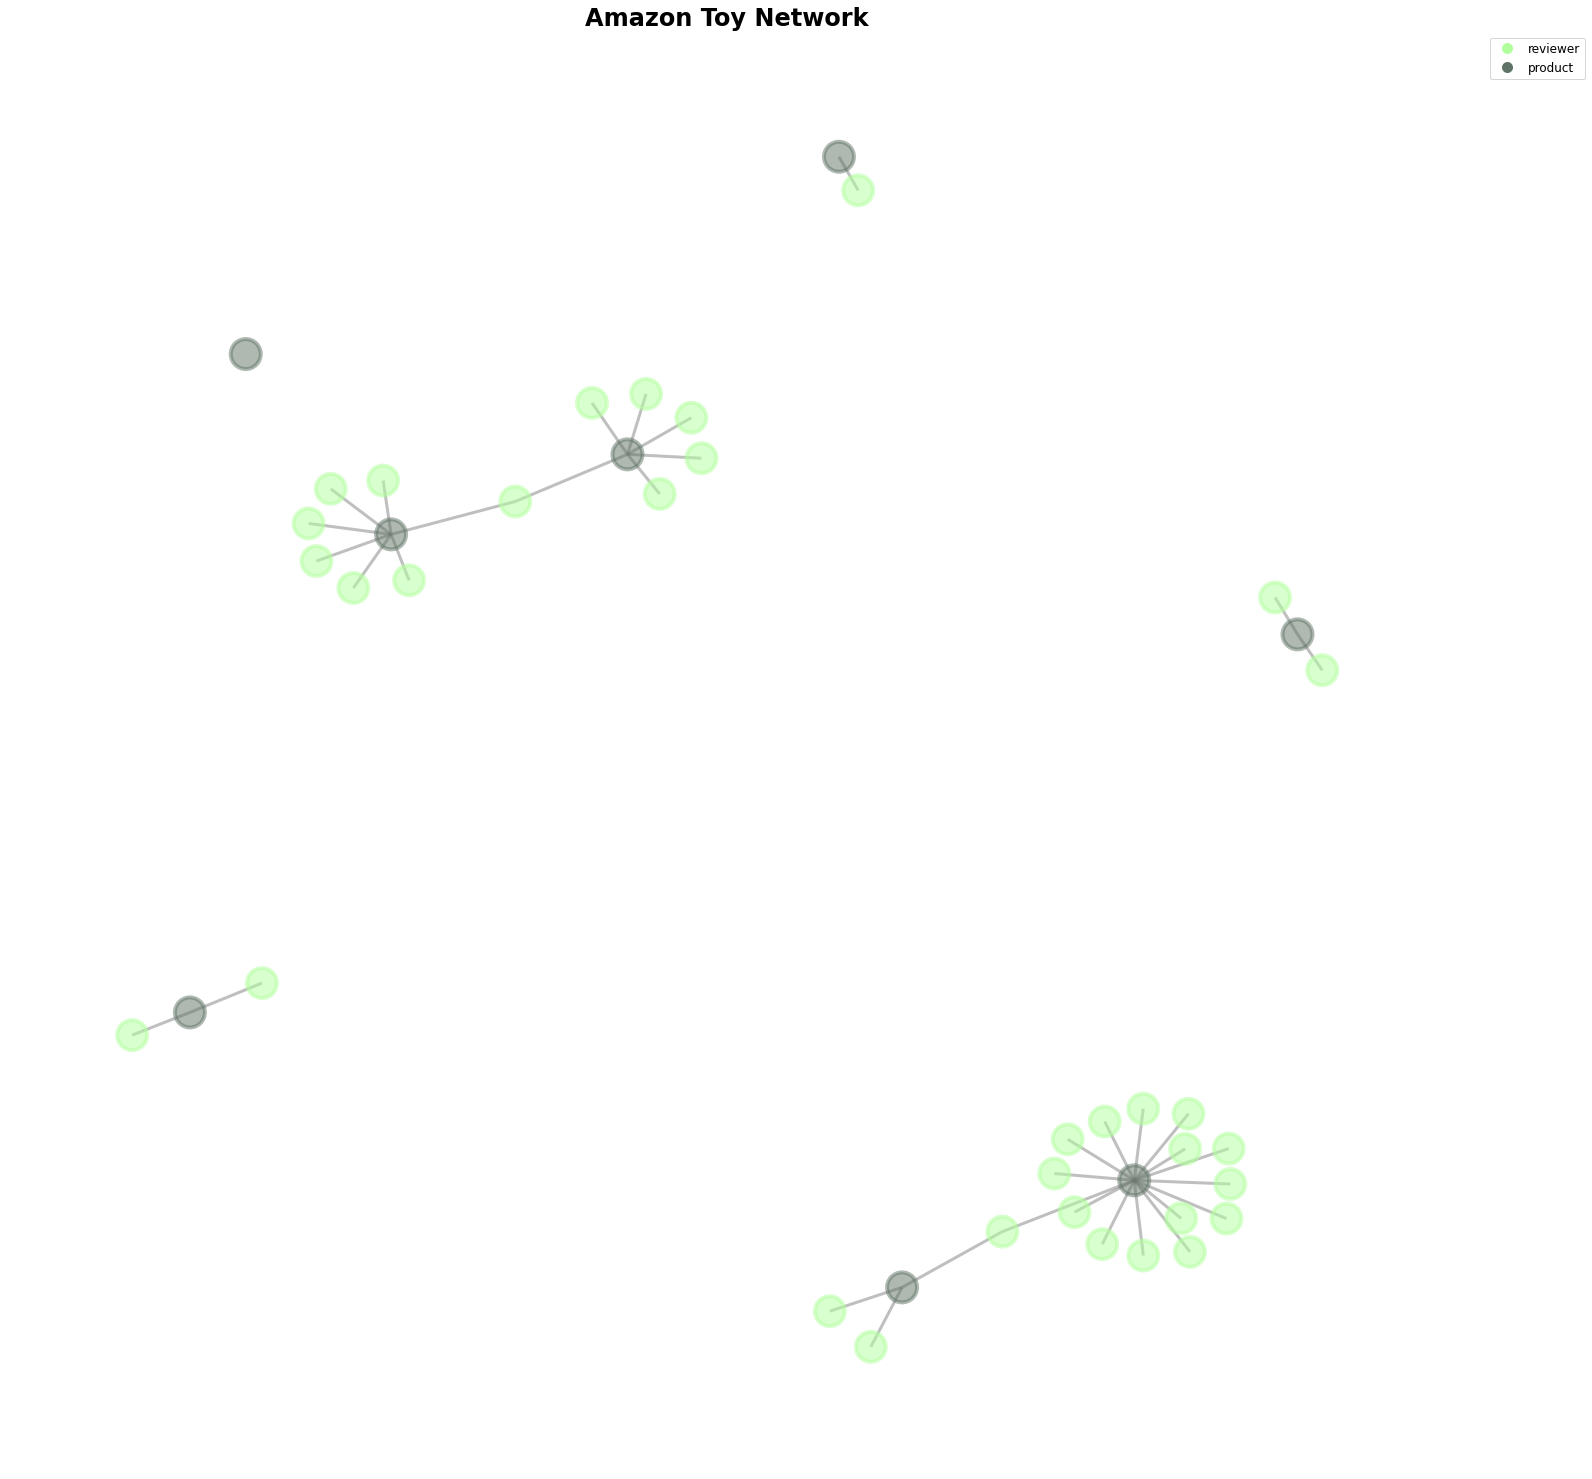

In [1]:
#Loading in our prep
import networkx as nx
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from networkx.algorithms import bipartite
import nltk
import re
import time
from sklearn.utils import shuffle
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import BernoulliNB



#Let's grab the product id as its label, for the cross matching later on
toy= nx.read_gml("amazon-toy.gml",label='label')
node_type=nx.get_node_attributes(toy,'type')

# Visualize the entire network
colors = []
color_map = { 'reviewer' : "#B2FF9E", 'product' : "#607466" }

for k in node_type:
    colors.append(color_map[node_type[k]])

plt.figure(figsize=(20, 20))

nx.draw(toy,
        font_size=18,
        font_weight="bold",
        font_color="black",
        node_size=900, 
        node_color=colors,
        edge_color="grey",
        node_shape="o", 
        alpha=0.5, 
        linewidths=4, 
        width=3)


legend_colors = list(color_map.values())
legend_texts = list(color_map.keys())

patches = [ plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=legend_colors[i], 
            label="{:s}".format(legend_texts[i]) )[0]  for i in range(len(legend_texts)) ]
plt.legend(
           handles=patches, 
           ncol=1, 
           numpoints=1, 
           fontsize = 12, 
           loc="upper right",
           bbox_to_anchor=(1.1, 1)
          )

plt.title("Amazon Toy Network", fontdict= { 'fontsize': 24, 'fontweight':'bold'}, loc='center')

plt.show()


### Developing Our Product List

For our analysis, let's sort the 2 node types for feature gathering. We created our product data frame with nodes of type 'product' filtered by node type. In this network, we can create our product list for the rating prediction and a dataframe for our product stats. The product statistics hosts any revelant data which can train a classifier to predict the product's overall rating in Amazon's marketplace.

In [2]:
#create a function that accepts a network graph to compute 
def product_create(G):
    product_list=[]
    product_details=[]
    P_Ids=[]
    p_l=[n for n, d in G.nodes(data=True) if d['type']=='product']
    p_g=G.subgraph(p_l)

    #creating a tuple list with only the product Id and overall product rating
    for n in p_g.nodes(data=True):
        product_list.append((n[0],n[1]['average_rating']))

    #gathering all details from the product nodes, will retrieve edge data from org list
    for n in p_g.nodes(data=True):
        P_Ids.append(n[0])
        product_details.append((n[0],n[1]['salesrank'],n[1]['reviews'],n[1]['title']))

    #the beginning of the product stats
    product_stats=pd.DataFrame(product_details,columns = ['Product_Id','Sales_Rank','Review_Count','Title'])
    return product_list,product_stats,P_Ids

product_list,product_stats,p_Ids=product_create(toy)
display(product_stats.head())

,Product_Id,Sales_Rank,Review_Count,Title
0,0963679600,59,16,IlluStory Book Kit
1,B000075A8O,7812,2,Party Tyme Karaoke CD Kids Songs
2,B000053W7W,10732,6,Party Tyme Karaoke CD: V2 Super Hits
3,0963679678,2288,3,Photostory Junior Book Kit
4,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera


### Retrieval of product reviews

Now, we can focus our attention on the available reviews for the product. The edge attributes holds the reviewer's opinon on the product: the date of the review,their rating, how many people agree with their rating, and how many people found their review helpful. We can use these statistics to create more guessing metrics.  The edges stats table created three new feautres from our reviews: the most voted rating, the most helpful rating, and the earliest rating available.

Now, we can join the two tables with a inner left join!


In [3]:
#function that will retrieve edge details 
def create_edetails(G,P_Ids):
    edge_details=[]
    edge_d=[]
    p_ids_dict = { id : 1 for id in P_Ids }

#    start_time = time.time()
    #if node is a product node, return its list of edge attributes into its own list
    for n in G.nodes(data=True):
        if n[0] in p_ids_dict:  
        #if n[0] in P_Ids:  
            #grab the edges from the specific node and apprend to edge details
            edges=G.edges(n[0],data=True)
            edges=list(edges)
            edge_d.append((edges))

#    print("--- %2.f seconds for n in G.nodes ---" % (time.time() - start_time))
#    start_time = time.time()

    #In order to grab the edges features: We have to iterate down the nested list for each edge
    for e in edge_d:
        for i in range(len(e)):
            #for each value, retreive values from the nested dic
            edge_details.append((e[i][0],e[i][2]['date'],e[i][2]['rating'],e[i][2]['votes'],e[i][2]['helpful']))
#    print("--- %2.f seconds for e in edge_d ---" % (time.time() - start_time))
#    start_time = time.time()

    #display(edge_details)
    #Create the edge details table and left join with product details table by P_ID
    edge_stats=pd.DataFrame(edge_details,columns = ['Product_Id','Date','Rating','Votes','Helpful'])
#    print("--- %2.f seconds pd.DataFrame ---" % (time.time() - start_time))

    return edge_stats

edge_stats=create_edetails(toy,p_Ids)
display(edge_stats.head())

,Product_Id,Date,Rating,Votes,Helpful
0,B000075A8O,2004-3-29,5,4,4
1,B000075A8O,2004-6-19,5,3,3
2,B000055XW3,2001-2-26,3,2,2
3,0963679600,2004-7-12,5,27,25
4,0963679600,1999-6-25,5,20,20


In [4]:
# function to for connectiveness metrics
def calc_connectiveness(g):
    start_time = time.time()

    only_products = []
    for id,values in g.nodes(data=True):
        if values['type'] == 'product':
            only_products.append(id)
            
    product_graph = nx.projected_graph(g, only_products)

    #eigenvector = nx.eigenvector_centrality(product_graph)
    #eigenvector = nx.eigenvector_centrality_numpy(product_graph)
    degrees = nx.degree(product_graph)
    #betweenness = nx.betweenness_centrality(product_graph)


    graph_metrics = []
    for id in only_products:
        graph_metrics.append( (id, degrees[id]) )
        dataframe_graph_metrics = pd.DataFrame(graph_metrics, columns = ['Product_Id','Degrees'])

    print("--- %2.f seconds for calc_connectiveness ---" % (time.time() - start_time))
    return dataframe_graph_metrics
    

connections = calc_connectiveness(toy)

---  0 seconds for calc_connectiveness ---


In [5]:
#function to return top rankings based on 
def find_rates(P_Ids,e):
    p_id_dict = {pid : 1 for pid in e['Product_Id'].unique()}
    rates=[]
    #Make rate values numeric
    e['Rating'] = pd.to_numeric(e['Rating'])
    e['Votes'] = pd.to_numeric(e['Votes'])
    e['Helpful'] = pd.to_numeric(e['Helpful'])
    
    temp_df = e.copy()
    temp_df.set_index('Product_Id', inplace=True)
    
    for i in range(len(P_Ids)):
        if P_Ids[i] in p_id_dict:
        #if P_Ids[i] in e.values:
            #filter for the specific product id in the table
            #temp= e[e['Product_Id'] == P_Ids[i]]
            temp= temp_df.loc[P_Ids[i]]
            
            if isinstance(temp, pd.core.frame.DataFrame):
                #Retrieve top values from .max and .min
                rates.append(
                    (P_Ids[i],
                     temp[temp['Votes']   ==temp.max()['Votes']]['Rating'].values[0],
                     temp[temp['Helpful'] ==temp.max()['Helpful']]['Rating'].values[0],
                     temp[temp['Date']    ==temp.min()['Date']]['Rating'].values[0])
                )
            else:
                rates.append(
                            (P_Ids[i], temp['Rating'], temp['Rating'], temp['Rating'])
                            )
        else:
        #If the Product Id has no reviews, return all zeros
            rates.append((P_Ids[i],0,0,0))

    r=pd.DataFrame(rates,columns=['Product_Id','Most_Voted_Rating','Most_Helpful_Rating','Earliest_Rating'])
    return r


In [6]:
top_rates=find_rates(p_Ids,edge_stats)
display(top_rates.head())

#combine the two tables into one
master=pd.merge(product_stats, top_rates, on="Product_Id", how="left")

master=pd.merge(master, connections, on="Product_Id", how="left")

display(master)

,Product_Id,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,0963679600,5,5,5
1,B000075A8O,5,5,5
2,B000053W7W,5,5,5
3,0963679678,5,5,5
4,B000055XW3,3,3,3


,Product_Id,Sales_Rank,Review_Count,Title,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating,Degrees
0,0963679600,59,16,IlluStory Book Kit,5,5,5,1
1,B000075A8O,7812,2,Party Tyme Karaoke CD Kids Songs,5,5,5,0
2,B000053W7W,10732,6,Party Tyme Karaoke CD: V2 Super Hits,5,5,5,1
3,0963679678,2288,3,Photostory Junior Book Kit,5,5,5,1
4,B000055XW3,31296,1,The Songs of Britney Spears & Christina Aguilera,3,3,3,0
5,B000059T05,4053,7,Party Tyme Karaoke CD Oldies,1,1,4,1
6,0963679627,45241,0,R- Photostory Senior,0,0,0,0
7,1572810939,1890,2,Wizard Card Game Deluxe,5,5,5,0


### Features for predicting the products rating

Now, we can create our feature lists with the master data frame. There are five types of recorded features: our baseline results, features based on rank and reviews, user input, and reviewer community features. 

There was no surprise that the test accuracy is insufficient. There are only eight products in the toy network. The classifier has limited cases to learn the differences between each amazon product. The  Amazon DVD network will show the results of our learnings from the toy network.

In [7]:
def no_features(product):
    return {'negative_one': 1 }

def rank_and_review_count(product):
    features = {}
    features['sales_rank'] =master.loc[master.Product_Id==product,'Sales_Rank'].values[0]
    features['review_count'] =master.loc[master.Product_Id==product,'Review_Count'].values[0]
    return features

def other_ratings(product):
    features = {}
    features['most_voted_rating'] = master.loc[master.Product_Id==product,'Most_Voted_Rating'].values[0]
    features['most_helpful_rating'] = master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    features['earliest_rating'] = master.loc[master.Product_Id==product,'Earliest_Rating'].values[0]
    return features

def ratings_connections(product):
    features = {}
    features['most_voted_rating'] = master.loc[master.Product_Id==product,'Most_Voted_Rating'].values[0]
    features['most_helpful_rating'] = master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    features['degrees'] = master.loc[master.Product_Id==product,'Degrees'].values[0]
    return features


def community_choice(product):
    features={}
    features['review_count']=master.loc[master.Product_Id==product,'Review_Count'].values[0]
    features['most_helpful_rating']= master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    features['sales_rank'] =master.loc[master.Product_Id==product,'Sales_Rank'].values[0]
    return features

def most_helpful(product):
    features={}
    features['most_helpful_rating']= master.loc[master.Product_Id==product,'Most_Helpful_Rating'].values[0]
    return features


all_features=[no_features,rank_and_review_count,other_ratings,ratings_connections,community_choice,most_helpful]

#shuffle product ids/ratings and split for testing
data=shuffle(product_list)
train_names,test_names = data[0:4], data[4:8]


In [8]:
def run_classfiyer(train_names,test_names,c):
    results_list = []

            # For each feature function, try to classify the test sets
    for fn in all_features:
        train_set = [(fn(n), g) for (n,g) in train_names]
        test_set = [(other_ratings(n), g) for (n,g) in test_names]

        
        # make a classifier from the training set, user can choose between NB, DT, Skylearn B
        opt=SklearnClassifier(BernoulliNB())
        classifier =nltk.NaiveBayesClassifier.train(train_set) if c==0 else nltk.DecisionTreeClassifier.train(train_set) if c==1 else opt.train(train_set)

                # Print the classifier logic
        accuracy_train = nltk.classify.accuracy(classifier, train_set)
        accuracy_test = nltk.classify.accuracy(classifier, test_set)

        results_list.append([fn.__name__, accuracy_train, accuracy_test])


        results_df = pd.DataFrame(results_list,
                                      columns=['Function', 
                                               'Training Accuracy', 
                                               'Test Accuracy',
                                               ])

    return results_df.head()

run_classfiyer(train_names,test_names,0)

,Function,Training Accuracy,Test Accuracy
0,no_features,0.75,0.25
1,rank_and_review_count,1.00,0.25
2,other_ratings,1.00,0.25
3,ratings_connections,1.00,0.25
4,community_choice,1.00,0.25


### Expanding our learning into a larger network | DVD reviews

In [9]:
start_time = time.time()
dvds = nx.read_gml("amazon-dvd.gml")
print("--- %2.f seconds to read gml file ---" % (time.time() - start_time))


--- 56 seconds to read gml file ---


In [10]:
#Following the steps from the toy network, let's create dvd's feature table
dvd_list,dvd_stats,dvd_Ids=product_create(dvds)
display(dvd_stats.head())

,Product_Id,Sales_Rank,Review_Count,Title
0,B000059H70,9755,17,Air Supply - The Definitive DVD Collection
1,B00006IUI3,23133,4,"Zatoichi the Blind Swordsman, Vol. 5 - On the ..."
2,B0000640W8,44482,5,Pearl Harbor/ Armageddon - 2 Pack
3,B00008IHF2,34061,3,O Pioneers!
4,B00000IC8D,51336,12,Things to Come/Journey to the Center of Time


In [11]:
# calculate the connection metrics
connections = calc_connectiveness(dvds)

--- 113 seconds for calc_connectiveness ---


In [12]:
#create dvd edge info table
edvd_stats=create_edetails(dvds,dvd_Ids)
display(edvd_stats.head())

,Product_Id,Date,Rating,Votes,Helpful
0,0790747324,1998-12-27,5,1,1
1,0790747324,2002-4-5,4,4,3
2,0790747324,1999-4-19,4,6,6
3,0790747324,1999-5-11,5,1,1
4,0790747324,1999-6-9,5,2,2


In [13]:
#find all the available ratings for the dvd network
#Will reduce our dvd Ids list for time consumption, cannot run on all 26K Products in the network 
start_time = time.time()
reduce_Ids=dvd_Ids

#prepare the product pool to only include the Ids we kept
re_list = [x for x in dvd_list if x[0] in reduce_Ids]

#find the top rates
t_rates=find_rates(reduce_Ids,edvd_stats)
display(t_rates.head())
print("--- %2.f seconds to find_rates ---" % (time.time() - start_time))


,Product_Id,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating
0,B000059H70,5,5,5
1,B00006IUI3,5,5,5
2,B0000640W8,1,5,5
3,B00008IHF2,5,5,5
4,B00000IC8D,1,1,5


--- 249 seconds to find_rates ---


In [14]:
#combine the two tables into one
master=pd.merge(dvd_stats, t_rates, on="Product_Id", how="left")

# Join again for the connection metriccs
master=pd.merge(master, connections, on="Product_Id", how="left")


#drop rows that where removed from the product reduction
display(master)

,Product_Id,Sales_Rank,Review_Count,Title,Most_Voted_Rating,Most_Helpful_Rating,Earliest_Rating,Degrees
0,B000059H70,9755,17,Air Supply - The Definitive DVD Collection,5,5,5,3754
1,B00006IUI3,23133,4,"Zatoichi the Blind Swordsman, Vol. 5 - On the ...",5,5,5,21
2,B0000640W8,44482,5,Pearl Harbor/ Armageddon - 2 Pack,1,5,5,3703
3,B00008IHF2,34061,3,O Pioneers!,5,5,5,3698
4,B00000IC8D,51336,12,Things to Come/Journey to the Center of Time,1,1,5,771
...,...,...,...,...,...,...,...,...
19823,B000068TPA,27374,11,Harry Chapin - Rockpalast Live,4,4,5,1339
19824,B00005UBKD,22325,21,Mobile Suit Gundam 0080 - War in the Pocket (V...,1,5,5,213
19825,6305428255,5682,296,She's All That,2,3,5,7841
19826,B00005OKQZ,14446,10,Aftershock: Earthquake in New York,1,5,1,1108


In [15]:
data=shuffle(re_list)
train_names,test_names = data[0:9914], data[9914:19828]

#Navies Bayers classifier results
run_classfiyer(train_names,test_names,0)




,Function,Training Accuracy,Test Accuracy
0,no_features,0.505850,0.502522
1,rank_and_review_count,0.883801,0.502522
2,other_ratings,0.584123,0.583216
3,ratings_connections,0.724329,0.588461
4,community_choice,0.897922,0.611257


In [16]:
#Decision Tree classifier results
run_classfiyer(train_names,test_names,1)

,Function,Training Accuracy,Test Accuracy
0,no_features,0.505850,0.502522
1,rank_and_review_count,0.998790,0.116603
2,other_ratings,0.649586,0.635263
3,ratings_connections,0.865039,0.116603
4,community_choice,0.999697,0.116603


In [17]:
#Skylearn classifier with Bernoulli model results
#run_classfiyer(train_names,test_names,3)

#we decided a variety of classifiers to determine if the particular model use affected our accuracy results
#The skylearn bernuolli model took over 20 minutes to load in its results and perform the worst out of all 
#the classifiers

### Final takeaways

The classifier's performance can now be accuracy seen with our scope of 19,828 Amazon DVDs. The network testing accurcy low score is due to the limited features supplied by its nodes. However, our suspicions were true that the best performance went to the most helpful rating. The functions community choice and most helpful had the best performance with the most helpful rating as a feature. These functions created a draw despite community choice's high training accuracy. There is a possibility that more exposure to the whole network may raise the test accuracy like with our switch from the toy network, but we currently do not have the device for that level of processing.

The learning we take away from this network is the importance of node features in a network. If there was room for detailed features like prominent review keywords attached to the edge features or more details of the reviewer's trust in the Amazon network, the machine had more insights for its judgement.